<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/casmeii-microexpresion/Microexpression_recognition_MicroExpSTCNN_CASMEII_Maestria_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Microexpresion recognition**
#**CASMEII Database**



**MicroExpSTCNN Model**

Natalia Zartha
Maestria en Ingenira de Sistemas y Computación, 2021

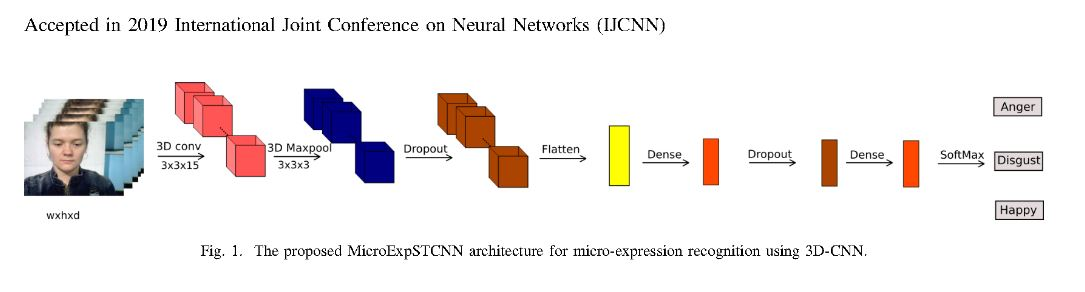

In [1]:
import os
import cv2
import numpy
import imageio
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras import backend as K
import sys
from matplotlib import pyplot as plt


#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

#Import files from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#CASMEII

#Load images

In [3]:
image_rows, image_columns, image_depth = 64, 64, 18

#angrypath = '../../workspace/micro-expression/data/angry/'
#happypath = '../../workspace/micro-expression/data/happy/'
#disgustpath = '../../workspace/micro-expression/data/disgust/'

training_list = []

CODE_PATH = 'drive/MyDrive/MAESTRIA ING DE SISTEMAS/1. MICROEXPRESIONES FACIALES TRABAJO DE GRADO/3. Codigo/microexpresion-recognition-colab/CASMEII'
CASMEII_path = CODE_PATH + '/datasets/CASMEII'

HSpath =CASMEII_path +'/CASME2_preprocessed_small_Li Xiaobai/Cropped/'
  

rootDirectory = os.listdir(HSpath)
for s in rootDirectory:
    sPath = HSpath + s + "/"
    microPath = os.listdir(sPath)
    for video in microPath:
        videopath = sPath + video

        frames = []
        framelisting = os.listdir(videopath)
        framesCount = image_depth if len(framelisting) > image_depth else 0
     
        print("framesCount")
        print(framesCount)

        framerange = [x for x in range(18)]

        if(framesCount != 0):
            for frame in framerange:
                  imagepath = videopath + "/" + framelisting[frame]

                  image = cv2.imread(imagepath)
                  imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                  grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                  frames.append(grayimage)

            frames = numpy.asarray(frames)
            videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
            
            training_list.append(videoarray)
            print(len(training_list))
   




framesCount
18
1
framesCount
18
2
framesCount
18
3
framesCount
18
4
framesCount
18
5
framesCount
18
6
framesCount
18
7
framesCount
18
8
framesCount
18
9
framesCount
18
10
framesCount
18
11
framesCount
18
12
framesCount
18
13
framesCount
18
14
framesCount
18
15
framesCount
18
16
framesCount
18
17
framesCount
18
18
framesCount
18
19
framesCount
18
20
framesCount
18
21
framesCount
18
22
framesCount
18
23
framesCount
18
24
framesCount
18
25
framesCount
18
26
framesCount
18
27
framesCount
18
28
framesCount
18
29
framesCount
18
30
framesCount
18
31
framesCount
18
32
framesCount
18
33
framesCount
18
34
framesCount
18
35
framesCount
18
36
framesCount
18
37
framesCount
18
38
framesCount
18
39
framesCount
18
40
framesCount
18
41
framesCount
18
42
framesCount
18
43
framesCount
18
44
framesCount
18
45
framesCount
18
46
framesCount
18
47
framesCount
18
48
framesCount
18
49
framesCount
18
50
framesCount
18
51
framesCount
18
52
framesCount
18
53
framesCount
18
54
framesCount
18
55
framesCount
18
56
f

#Training

In [4]:
#257 imagenes que se conviernes en escala de gris
#64x64 tamaño
#18 frames 


training_list = numpy.asarray(training_list)
trainingsamples = len(training_list)

print("trainingsamples")
print(trainingsamples)

traininglabels = numpy.zeros((trainingsamples, ), dtype = int)

traininglabels[0:66] = 0
traininglabels[66:113] = 1
traininglabels[113:156] = 2

traininglabels = np_utils.to_categorical(traininglabels, 3)

training_data = [training_list, traininglabels]
(trainingframes, traininglabels) = (training_data[0], training_data[1])

training_set = numpy.zeros((trainingsamples, 1, image_rows, image_columns, image_depth))

print("range(trainingsamples) is the value of h")
print(range(trainingsamples))

for h in range(trainingsamples):
    training_set[h][0][:][:][:] = trainingframes[h, :, :, :]


training_set = training_set.astype('float32')
training_set -= numpy.mean(training_set)
training_set /= numpy.max(training_set)

print("training_set.shape")
print(training_set.shape)

# Save training images and labels in a numpy array
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy', training_set)
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy', traininglabels)

# Load training images and labels that are stored in numpy array
"""
training_set = numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy')
traininglabels =numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy')
"""

trainingsamples
257
range(trainingsamples) is the value of h
range(0, 257)
training_set.shape
(257, 1, 64, 64, 18)


"\ntraining_set = numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy')\ntraininglabels =numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy')\n"

#Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 62, 62, 4)     4352      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 20, 20, 1)     0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 20, 20, 1)     0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1638528   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

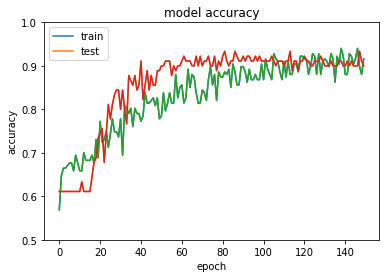

--------------------------------------


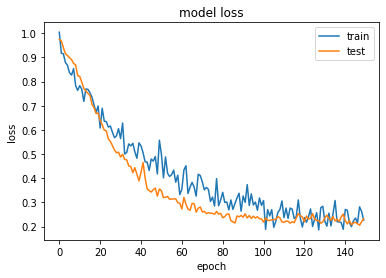

In [5]:

# MicroExpSTCNN Model
model = Sequential()
model.add(Convolution3D(32, (3, 3, 15), input_shape=(1, image_rows, image_columns, image_depth), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(128, init='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(3, init='normal'))
model.add(Dense(3, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

model.summary()

filepath=CODE_PATH+"/weights_microexpstcnn/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
######filepath=CODE_PATH+"/weights_microexpstcnn/model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Load pre-trained weights
#model.load_weights(CODE_PATH+'/weights_microexpstcnn/weights-improvement-40-0.69.hdf5')
#model.load_weights(CODE_PATH+'/weights_microexpstcnn/model_weights.h5')

# Spliting the dataset into training and validation setsl
train_images, validation_images, train_labels, validation_labels =  train_test_split(training_set, traininglabels, test_size=0.35, random_state=4)

# Save validation set in a numpy array
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy', validation_images)
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy', validation_labels)

# Load validation set from numpy array
validation_images = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy')
validation_labels = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy')


# Training the model
#hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, nb_epoch = 100, shuffle=True)
hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, epochs = 150, shuffle=True)


plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


test_loss, test_acc = model.evaluate(validation_images,  validation_labels, verbose=2)
print("test_acc")
print(test_acc)


import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



print("--------------------------------------")

plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#Predictions


In [6]:

# Finding Confusion Matrix using pretrained weights

print("------------------validation_images--------------------")
print(validation_images.shape)
print(validation_images)
print("------------------validation_labels--------------------")
print(validation_labels.shape)
print(validation_labels)



predictions = model.predict(validation_images)
predictions_labels = numpy.argmax(predictions, axis=1)


print("-------------------predictions------------------------")
print(predictions)
print("-------------------predictions_labels-----------------")
print(predictions_labels.shape)
print(predictions_labels)

validation_labels_y = numpy.argmax(validation_labels, axis=1)



print("-------------------validation_labels_new---------------")
print(validation_labels_y.shape)
print(validation_labels_y)

cfm = confusion_matrix(validation_labels_y, predictions_labels)
print("------------------------------confusion_matrix------------------------------")
print (cfm)

print('Accuracy score :', accuracy_score(validation_labels_y,predictions_labels) )


print('Classification report :', classification_report(validation_labels_y,predictions_labels) )


#precision, recall, thresholds = precision_recall_curve(validation_labels_y,predictions_labels)


from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, hamming_loss, jaccard_similarity_score, log_loss, zero_one_loss, matthews_corrcoef

#https://www.programcreek.com/python/example/86675/sklearn.metrics.roc_auc_score
#https://aprendeia.com/metricas-de-evaluacion-clasificacion-con-scikit-learn-machine-learning/   PARA DOCUMENTAR LAS METRICAS

print("------------------------------return all metrics results------------------------------")
print("--------------------------------------------------------------------------------------")

def evaluation_analysis(true_label,predicted): 
    '''
    return all metrics results
    '''
    print("accuracy (EXACTITUD)",accuracy_score(true_label, predicted))
    print("f1 score macro",f1_score(true_label, predicted, average='macro'))     
    print("f1 score micro",f1_score(true_label, predicted, average='micro'))
    print("precision score (PRESICION)",precision_score(true_label, predicted, average='macro'))
    print("recall score (SENSIBILIDAD)",recall_score(true_label, predicted, average='macro'))
    print("hamming_loss",hamming_loss(true_label, predicted))
    print("classification_report", classification_report(true_label, predicted))
    print("jaccard_similarity_score", jaccard_similarity_score(true_label, predicted))
    #print("log_loss", log_loss(true_label, predicted))
    print("zero_one_loss", zero_one_loss(true_label, predicted))
    #print("AUC&ROC",roc_auc_score(true_label, predicted))
    print("matthews_corrcoef", matthews_corrcoef(true_label, predicted)) 




evaluation_analysis(validation_labels_y,predictions_labels)

------------------validation_images--------------------
(90, 1, 64, 64, 18)
[[[[[-0.11355539 -0.11355539 -0.13405026 ... -0.13405026 -0.14771353
     -0.12721865]
    [-0.18187167 -0.18187167 -0.1682084  ... -0.1887033  -0.18187167
     -0.20236655]
    [-0.15454516 -0.1408819  -0.16137679 ... -0.11355539 -0.12721865
     -0.13405026]
    ...
    [-0.09989213 -0.09989213 -0.10672376 ... -0.09989213 -0.11355539
     -0.10672376]
    [-0.16137679 -0.15454516 -0.14771353 ... -0.13405026 -0.15454516
     -0.15454516]
    [-0.20919818 -0.20919818 -0.20919818 ... -0.20236655 -0.21602981
     -0.21602981]]

   [[-0.15454516 -0.14771353 -0.14771353 ... -0.1408819  -0.1682084
     -0.14771353]
    [-0.14771353 -0.15454516 -0.1408819  ... -0.12721865 -0.15454516
     -0.13405026]
    [-0.12721865 -0.12038702 -0.11355539 ... -0.11355539 -0.10672376
     -0.12721865]
    ...
    [-0.09989213 -0.0930605  -0.10672376 ... -0.09989213 -0.09989213
     -0.0930605 ]
    [-0.15454516 -0.12038702 -0.14088

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#ROC and Precision-Recall curves

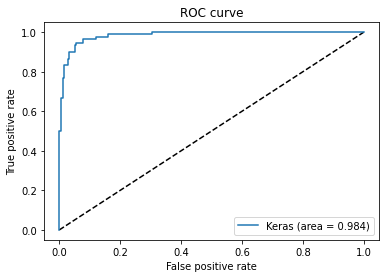

In [7]:
X_train = train_images
y_train = train_labels
X_test = validation_images
Y_test = validation_labels



#https://webmonkez.com/questions/1637057/como-encontrar-la-curva-roc-y-la-puntuacion-auc-del-modelo-cnn-keras

import numpy as np
from sklearn import metrics

prediction = model.predict(validation_images)



from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test.ravel(), y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


 

In [8]:
train_images.shape


(167, 1, 64, 64, 18)

In [9]:
validation_images.shape

(90, 1, 64, 64, 18)

In [10]:

#y_predit = model.predict(train_images[:,:,:,:,14])








#revisar x el que el train_images.shape esta dando con el  4, 1


#revisar el modelo 

#por que los traingns deben ser asi
#traings
#1, 64, 64, 3

#todas las imagenes 
#18, 1, 64, 64, 3

#y revisar por que solo se tienen 18 imagenes

#Save model as json string

In [11]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)